# Metropolis-Hastings and Gibbs Sampling

## Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) methods are used in Bayesian parameter estimation when the prior is assumed and the likelihood is known, but the posterior is not analytically tractable.

Although the posterior is unknown, properties of the posterior can be obtained if sampling from it is possible. This can be achieved by using a MCMC method which approximates the posterior, and such algorithms usually require another distribution proportional to the posterior to be known. Bayes' rule states that the joint distribution of the likelihood and the prior is proportional to the posterior:

$$
P(\theta | y) \propto P(y | \theta) \times P(\theta)
$$

Therefore MCMC is possible for Bayesian inference.

## Metropolis-Hastings

Metropolis-Hastings is undoubtedly the most famous MCMC method. 

Let the joint distribution of the likelihood and the prior be $g(\theta)$, a simple version of the algorithm involves the following steps:

1. For $\theta$ whose posterior is the target distribution, select an arbitrary starting point $\theta_0$

2. For $i = 1, ..., m$:

    1. Draw a candidate $\theta^{*}$ from a proposal distribution $q(\theta^{*} | \theta_{i-1})$. A common choice for the proposal distribution is a normal distribution centred around $\theta_{i-1}$
    
    2. Calculate the joint distribution using the candidate, $g(\theta^{*})$, and that using the previous value, $g(\theta_{i-1})$. Then calculate acceptance ratio $\alpha$, which can be defined in different ways but commonly $\alpha \propto \frac{g(\theta^{*})}{g(\theta_{i-1})}$
    
    3. Either accept candidate $\theta^{*}$, or reject it and reuse the previous value $\theta_{i-1}$
    
        - If $g(\theta^{*})$ gives a greater value than $g(\theta_{i-1})$, i.e. $\alpha \geq 1$, accept $\theta^{*}$ as $\theta_i$
        
        - If $g(\theta^{*})$ gives a smaller value than $g(\theta_{i-1})$, i.e. $0 < \alpha < 1$, accept $\theta^{*}$ as $\theta_i$ with probability $\alpha$, or reject $\theta^{*}$ and set $\theta_{i-1}$ as $\theta_i$ with probability $1- \alpha$
        
The resulting chain of $\theta$ is the approximation of the posterior.

In [1]:
library(magrittr) # makes some codes more readable

### An Example

This is based on an example, with modifications, from Farrell & Lewandowsky (2018).

Suppose a person obtained a score of 120 in an intelligence test. It is known that test scores are normally distributed among the general population with $\sigma = 15$.

The parameter of interest is the mean score $\mu$ and it is assumed that its prior is uniformly distributed.

The posterior of $\mu$ can be estimated with Metropolis-Hastings (although it is in fact analytically tractable). A uniform prior can be eliminated from the equation since it does not affect the proportionality between the posterior and the likelihood. The likelihood is simple as it is a normal distribution with known standard deviation.

In [2]:
set.seed(42)

score<-120

sigma<-15

chain<-c(100) # starting value

for (i in 2:10000){
    
    mu_previous<-chain[i-1] # the previous value in the chain
    
    mu_candidate<-mu_previous + rnorm(1, 0, 5) # the proposal is the previous value plus a random value with mean 0, hence centred around the previous value
    
    alpha<-dnorm(score, mu_candidate, sigma)/dnorm(score, mu_previous, sigma) # acceptance ratio, which is calculated using likelihoods
    
    if (!(alpha<1)){ # alpha >= 1
        
        chain<-c(chain, mu_candidate)
        
    } else {
        
        mu_current<-ifelse(runif(1)<alpha, mu_candidate, mu_previous)
        
        chain<-c(chain, mu_current)
        
    }

}

The posterior distribution is shown as below:

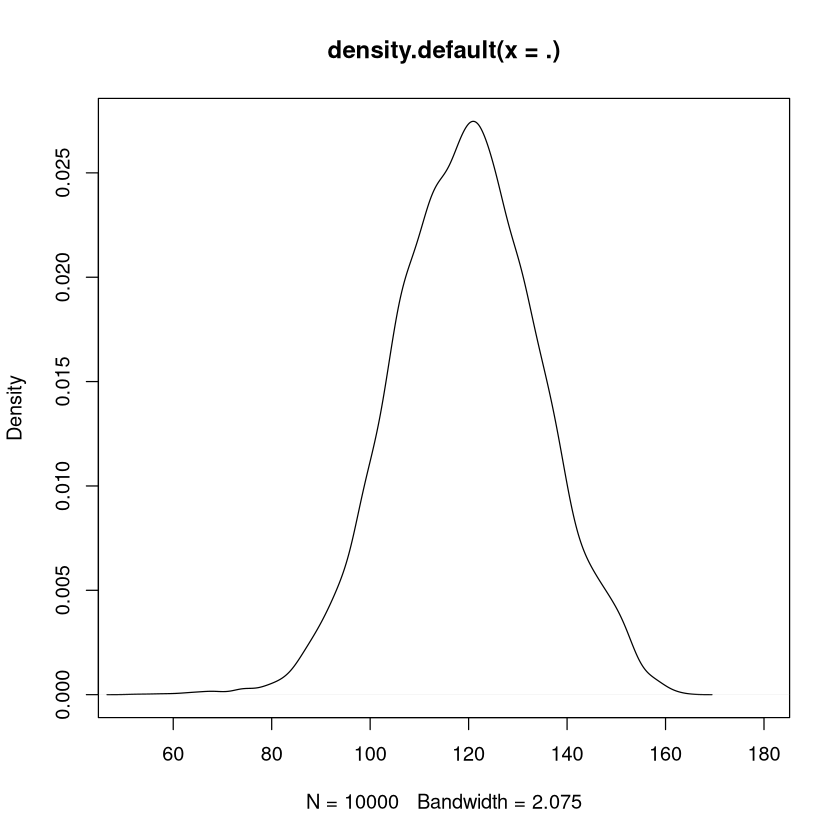

In [3]:
chain %>% density %>% plot(xlim=c(50, 180))

In [4]:
mean(chain)

[1] 119.6389

The expected probability density is as follows, with $\mu = 120$ and $\sigma = 15$. Recoverability is good.

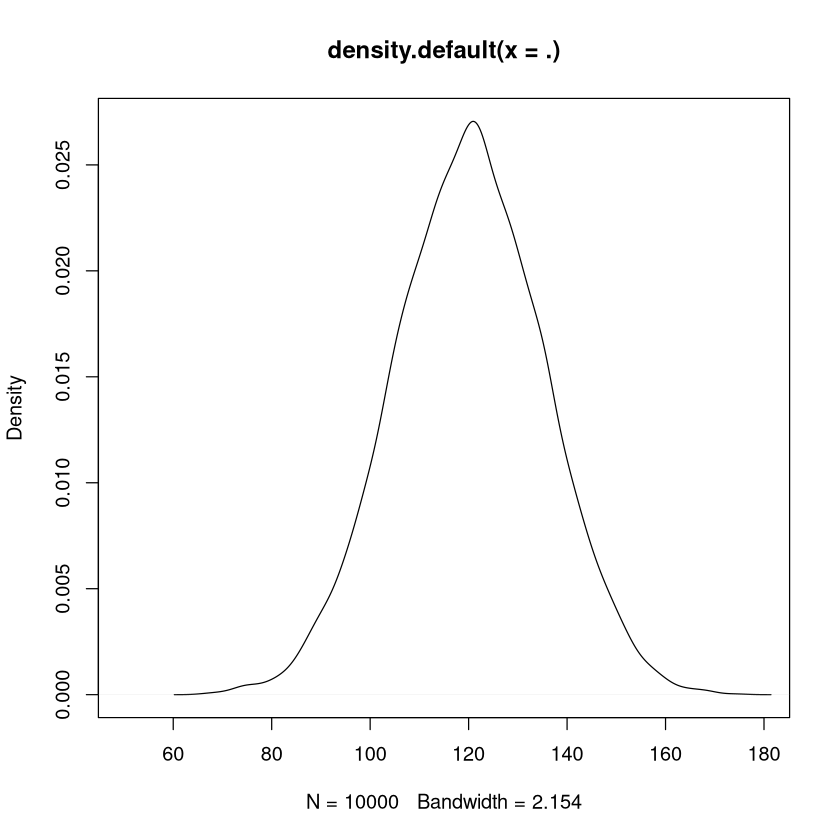

In [5]:
expected<-rnorm(10000, 120, 15)

expected %>% density %>% plot(xlim=c(50, 180))

### Another Example

Consider that the above mentioned person with a test score of 120 is believed to be gifted. It is known that the population of intelligent individuals has a $\sigma_x = 5$. The parameter of interest is the mean $\mu_x$ of this population.

A prior is assumed based on information about the general population, with $\mu_0 = 100$ and $\sigma_0 = 15$. This is more realistic than the above uniform prior, since the latter is psychological impossible and allows intelligence to reach infinity on both ends.

A key difference from the previous example is that the $g$ function is calculated based on not just the likelihood, but also the prior.

In [6]:
set.seed(42)

score<-120
sigma_x<-5

mu_0<-100
sigma_0<-15

chain<-c(100) # starting value

for (i in 2:10000){
    
    mu_previous<-chain[i-1]
    
    mu_candidate<-mu_previous + rnorm(1, 0, 5)
    
    g_candidate<-dnorm(score, mu_candidate, sigma_x)*dnorm (mu_candidate, mu_0, sigma_0)
    
    g_previous<-dnorm(score, mu_previous, sigma_x)*dnorm(mu_previous, mu_0, sigma_0) 
    
    alpha<-g_candidate/g_previous
    
    if (!(alpha<1)){ # alpha >= 1
        
        chain<-c(chain, mu_candidate)
        
    } else {
        
        mu_current<-ifelse(runif(1)<alpha, mu_candidate, mu_previous)
        
        chain<-c(chain, mu_current)
        
    }

}

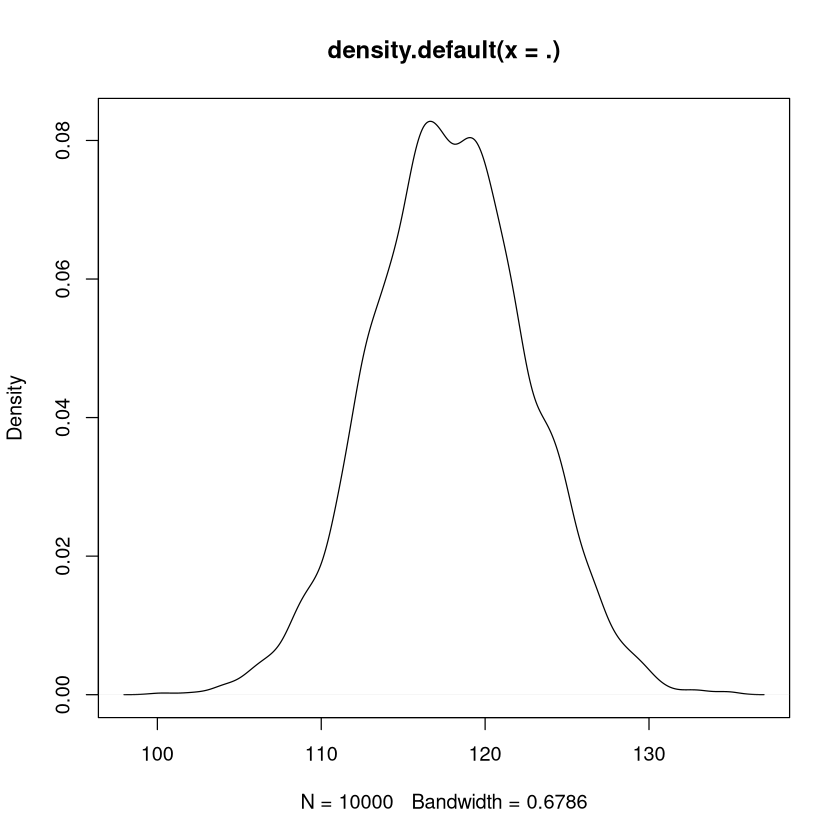

In [7]:
chain %>% density %>% plot

In [8]:
mean(chain)

[1] 117.8662

## Gibbs Sampling

Metropolis-Hastings is useful in estimating the posterior of a single parameter, but it is complicated for multiple parameters since it requires the sampling and acceptance/rejection of all candidates at the same time.

A common alternative MCMC method is Gibbs sampling, which samples one parameter at a time.

Given two parameters $\theta$ and $\phi$, the joint posterior is $p(\theta, \phi | y)$. This unknown distribution can be sampled if the full conditional distributions $p(\theta | \phi, y)$ and $(\phi | \theta, y)$ are known, both of which are proportional to $p(\theta, \phi)$.

The algorithm is as follows:

1. Select starting values $\theta_0$ and $\phi_0$

2. For $i = 1, ..., m$:

    1. Draw $\theta_i$ from the conditional distribution $p(\theta | \phi_{i-1}, y)$
    
    2. Draw $\phi_i$ from the conditional distribution $p(\phi | \theta_{i}, y)$
    
When using full conditional distributions as proposal distributions, the acceptance ratio is exactly 1 in most versions of Gibbs sampling. Hence, unlike Metropolis-Hastings, acceptance ratio is not implemented in the algorithm.

### An Example

This is based on an example, with modifications, from Heiner (2017).

Consider a data $\mathbf{y}$ which contains the changes in revenue of $n$ companies in the past year (in £1,000,000). Assume a normal likelihood with unknown mean and variance:

$$
y_i | \mu, \sigma^2 \sim N(\mu, \sigma^2), i = 1, ..., n
$$

A normal prior is used for the mean:

$$
\mu \sim N(\mu_0, \sigma_0^2)
$$

and an inverse gamma prior is used for the variance:

$$
\sigma^2 \sim \text{IG}(\nu_0, \beta_0)
$$

The most complicated part of Gibbs sampling is that it requires full conditional distributions to be known. In this example:

$$
p(\mu | \sigma^2, y_1, ..., y_n) \propto
N(\mu | \frac{ \frac{ n \bar{y} }{\sigma^2} + \frac{\mu_0}{\sigma_0^2} } { \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} }, \frac{1}{ \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} })
$$

$$
p(\sigma^2 | \mu, y_1, ..., y_n) \propto
\text{IG}(\sigma^2 | \nu_0 + \frac{n}{2}, \beta_0 + \frac{ \sum^n_{i=1} (y_i - u)^2 }{2})
$$

In [9]:
# sets data and hyperparameters

y<-c(1.2, 1.4, -.5, .3, .9, 2.3, 1, .1, 1.3, 1.9)

y_bar<-mean(y)
n<-length(y)

mu_0<-0
sigma2_0<-1 
nu_0<-1
beta_0<-1

In [10]:
set.seed(42)

chain_sigma2<-integer(0) # no need to initalise sigma2, since the first value of sigma2 will be drawn

chain_mu<-c(1)

for (i in 2:10000){
    
    sigma2_current<-1/rgamma(1, shape=(nu_0 + n/2), rate=(beta_0 + sum((y-chain_mu[i-1])^2)/2)) # inverse gamma is needed
    
    mu_current<-rnorm(1, mean=((n*y_bar)/sigma2_current + mu_0/sigma2_0)/(n/sigma2_current + 1/sigma2_0), sd=sqrt(1/(n/sigma2_current + 1 / sigma2_0))) # sqrt() is used since standard deviation is needed
    
    chain_sigma2<-c(chain_sigma2, sigma2_current)
    
    chain_mu<-c(chain_mu, mu_current)

}

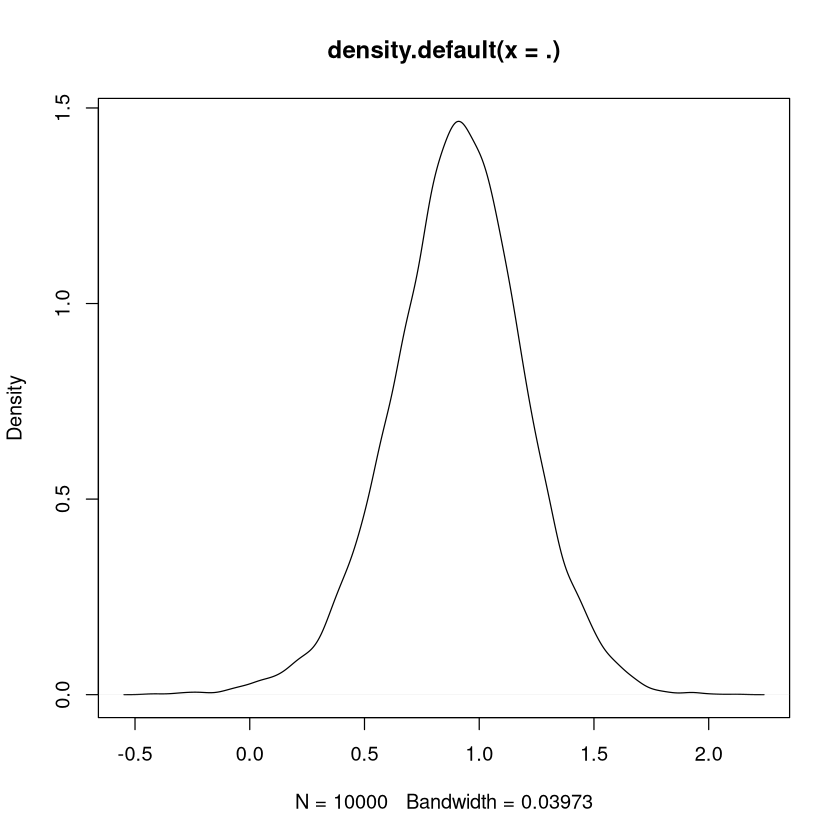

In [11]:
chain_mu %>% density %>% plot

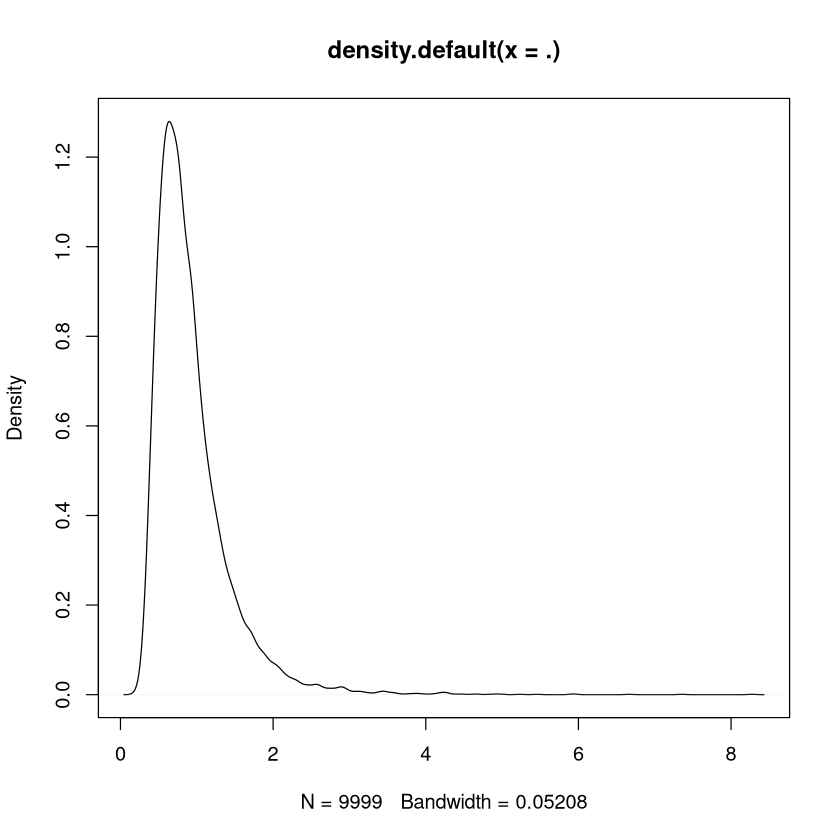

In [12]:
chain_sigma2 %>% density %>% plot